In [1]:
%load_ext autoreload
%autoreload 2

import polars as pl
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from src.utils import test_train_split
from test import test_labels
import tqdm
import tabulate

import os
os.getcwd()

'/home/yitao/projects/Saccade-Project'

# Feature Selections

In this modeling, we apply all the technical indicators that TA-Lib has, however,some of them may be not efficient to be applied in the modeling and some of them may have 'perfect linearity'. Hence we have to perform feature selections

In [2]:
vif = pl.read_csv('vif.csv').transpose(include_header=True).rename({'column': 'Features', 'column_0': 'VIF'})
vif_selected_features = vif.filter(pl.col('VIF') < 100)['Features'].to_list()
vif_selected_features.remove('const')
vif

Features,VIF
str,f64
"""const""",0.0
"""open""",1.0088e8
"""high""",1.9041e8
"""low""",1.8746e8
"""close""",3.6339e8
"""volume""",10.136393
"""num_trade""",32.352948
"""last_bid""",1.2010e9
"""last_ask""",1.0648e9


With the selected features from VIF, we still wanna see the linear relationship between the features and the labels that we want to predict.

In [3]:
data = pl.scan_ipc("./data/Stocks/*.arrow")
# do simple feature selections
targets = ['log_close', 'log_open', 'log_vwap', 'log_mid', 'log_twap_mid']
#
clean_data= data.select(vif_selected_features + targets).collect()
corrs = clean_data.corr().transpose(include_header=True).rename({f'column_{i}': vif_selected_features[i] for i in range(len(vif_selected_features))})
corrs

column,volume,num_trade,num_lift,lift_volume,num_hit,hit_volume,hit_pressure,lift_pressure,imb_ratio,lift_pre,lift_change,hit_pre,hit_change,HT_DCPERIOD,HT_DCPHASE,HT_PHASOR_0,HT_PHASOR_1,HT_SINE_0,HT_SINE_1,HT_TRENDMODE,DIV,SUB,COS,SIN,TAN,TANH,ADX,ADXR,BOP,CCI,DX,MACDEXT_1,MACDEXT_2,MFI,MINUS_DI,MINUS_DM,…,CDLCLOSINGMARUBOZU,CDLDOJI,CDLDOJISTAR,CDLENGULFING,CDLGAPSIDESIDEWHITE,CDLGRAVESTONEDOJI,CDLHAMMER,CDLHANGINGMAN,CDLHARAMI,CDLHARAMICROSS,CDLHIGHWAVE,CDLHIKKAKE,CDLINVERTEDHAMMER,CDLLONGLEGGEDDOJI,CDLLONGLINE,CDLMARUBOZU,CDLMATCHINGLOW,CDLRICKSHAWMAN,CDLSEPARATINGLINES,CDLSHORTLINE,CDLSPINNINGTOP,CDLTRISTAR,BETA,CORREL,STDDEV,VAR,ATR,NATR,TRANGE,AD,ADOSC,OBV,column_81,column_82,column_83,column_84,column_85
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""volume""",1.0,0.302096,0.238246,0.772783,0.242567,0.786246,0.02893,0.023704,0.051728,0.049079,0.13404,-0.052002,0.134707,-0.044179,0.002106,0.001522,0.000073,-0.000903,-0.004272,0.010098,0.251665,-0.014143,-0.05558,-0.045908,-0.000301,-0.109759,0.102616,0.106883,0.004824,0.006138,0.076623,0.003353,0.000614,0.006945,-0.108504,-0.060186,…,0.005935,-0.067924,-0.003426,0.00093,-0.000158,0.025248,0.014296,-0.025503,-0.000475,-0.000331,0.054293,-0.000023,0.01119,0.06189,0.003112,0.003448,-0.016921,0.053071,-0.027074,-0.064634,0.054334,0.008731,-0.018003,-0.052046,-0.044654,-0.00898,-0.054259,0.213841,-0.023196,0.195034,0.072288,0.204219,0.002584,0.002211,0.003421,-0.002257,0.001693
"""num_trade""",0.302096,1.0,0.862454,0.246472,0.866976,0.248761,0.086589,0.071956,-0.016754,-0.11636,0.256562,0.09619,0.256675,0.057082,-0.007753,0.000369,0.000961,0.000382,-0.004386,0.051516,0.357267,0.560503,0.000831,0.007127,-0.002885,0.00419,0.012899,0.000808,0.009933,0.009292,0.050936,0.003501,0.005304,0.018589,-0.121737,0.388222,…,0.012288,-0.25015,-0.004365,-0.073037,-0.001109,0.009395,0.020674,-0.001036,-0.000548,0.003662,0.182001,0.002479,0.011235,0.078496,0.006627,0.007887,-0.054575,0.158245,-0.025651,-0.18072,0.188539,-0.005733,0.02368,0.125571,0.42263,0.345136,0.472677,0.236364,0.532877,0.042846,0.026892,0.033648,0.003661,0.001852,0.003853,0.001383,0.000379
"""num_lift""",0.238246,0.862454,1.0,0.30693,0.542215,0.11632,-0.126137,0.281993,-0.076696,-0.015263,0.421571,0.187549,0.025817,0.051378,-0.016911,-0.017259,-0.006934,-0.015393,0.005814,0.04697,0.303961,0.498025,0.001584,0.003746,-0.003125,0.00434,0.00465,-0.006483,-0.148712,-0.134526,0.042517,-0.019584,-0.020153,-0.052479,-0.069872,0.384667,…,-0.12508,-0.21992,-0.000334,-0.099034,-0.011555,0.039938,0.031788,0.036476,-0.011674,-0.002199,0.165519,0.006494,0.028295,0.073229,-0.108735,-0.103792,-0.03701,0.145251,-0.081219,-0.174263,0.170268,-0.007513,0.035087,0.118884,0.379237,0.309163,0.431423,0.210654,0.473894,0.035262,-0.030448,0.02686,0.002041,0.000199,0.005948,0.015181,-0.001311
"""lift_volume""",0.772783,0.246472,0.30693,1.0,0.114505,0.354616,-0.079678,0.141135,-0.029902,0.061889,0.215668,-0.02673,0.021313,-0.037168,-0.000398,0.000682,-0.000143,-0.007943,-0.001765,0.010041,0.216836,-0.013181,-0.04706,-0.041241,-0.000603,-0.098652,0.085126,0.088481,-0.05969,-0.063379,0.066084,0.001706,-0.001337,-0.034274,-0.080224,-0.049051,…,-0.056487,-0.058363,-0.002579,-0.001773,-0.005964,0.037021,0.022982,-0.00466,-0.001663,-0.000883,0.04957,0.000372,0.020151,0.057254,-0.049552,-0.047942,-0.009261,0.049024,-0.056303,-0.059377,0.04942,0.002298,-0.01089,-0.039524,-0.039187,-0.00787,-0.046499,0.191413,-0.021067,0.169145,-0.03522,0.179723,0.000743,0.000307,0.003777,0.003623,-0.00013
"""num_hit""",0.242567,0.866976,0.542215,0.114505,1.0,0.306651,0.293052,-0.135682,0.04619,-0.18894,0.027064,-0.011435,0.418383,0.056002,0.001735,0.017889,0.009689,0.01724,-0.012663,0.047708,0.314005,0.497316,0.001227,0.010

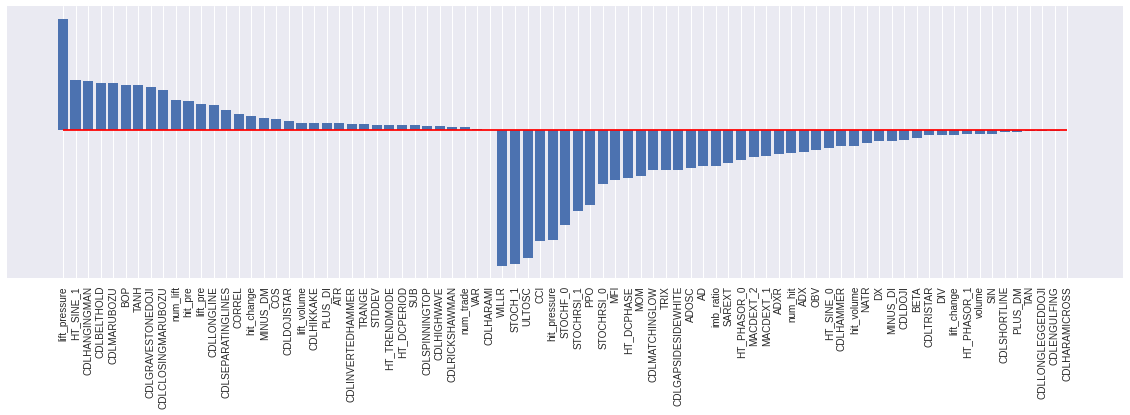

In [4]:
log_mid = corrs.filter(pl.col('column') == 'log_mid').drop(['column_81','column_82','column_83','column_84','column_85' ]).transpose(include_header=True).rename({'column': 'Features', 'column_0': 'Corr'}).sort('Corr', descending=True)
plt.style.use('seaborn')
plt.figure(figsize=(20, 5))
plt.bar(x=np.arange(len(log_mid[1:])),height=log_mid[1:].select(pl.col('Corr').cast(pl.Float32))['Corr'].to_numpy())
plt.xticks(np.arange(len(log_mid[1:])), log_mid[1:]['Features'].to_list(), rotation=90)
plt.hlines(0, 0, 80, colors='red')
plt.yticks([], [])
plt.show()

In [5]:
log_mid = log_mid[1:].with_columns(pl.col('Corr').cast(pl.Float32))

Drop the bottom 10% of positive corr features and top 10% of negative corr features

In [6]:
corr_selected_features0 = log_mid.filter(pl.col('Corr') > 0).filter(pl.col('Corr') > pl.col('Corr').quantile(0.1))['Features']
corr_selected_features1 = log_mid.filter(pl.col('Corr') < 0).filter(pl.col('Corr') < pl.col('Corr').quantile(0.9))['Features']
corr_selected_features = pl.concat([corr_selected_features0, corr_selected_features1])
corr_selected_features.to_frame().write_csv('selected_features.csv')

In [7]:
corr_selected_features

Features
str
"""lift_pressure"""
"""HT_SINE_1"""
"""CDLHANGINGMAN"""
"""CDLBELTHOLD"""
"""CDLMARUBOZU"""
"""BOP"""
"""TANH"""
"""CDLGRAVESTONED…"
"""CDLCLOSINGMARU…"


## Label selections & Model Selections

To make it simple we use part of the data to train three models [OLS, Ridge and RF], with five log return labels and pick one of the best combinations

In [10]:
corr_selected_features.to_list()

['lift_pressure',
 'HT_SINE_1',
 'CDLHANGINGMAN',
 'CDLBELTHOLD',
 'CDLMARUBOZU',
 'BOP',
 'TANH',
 'CDLGRAVESTONEDOJI',
 'CDLCLOSINGMARUBOZU',
 'num_lift',
 'hit_pre',
 'lift_pre',
 'CDLLONGLINE',
 'CDLSEPARATINGLINES',
 'CORREL',
 'hit_change',
 'MINUS_DM',
 'COS',
 'CDLDOJISTAR',
 'lift_volume',
 'CDLHIKKAKE',
 'PLUS_DI',
 'ATR',
 'CDLINVERTEDHAMMER',
 'TRANGE',
 'STDDEV',
 'HT_TRENDMODE',
 'HT_DCPERIOD',
 'SUB',
 'CDLSPINNINGTOP',
 'CDLHIGHWAVE',
 'WILLR',
 'STOCH_1',
 'ULTOSC',
 'CCI',
 'hit_pressure',
 'STOCHF_0',
 'STOCHRSI_1',
 'PPO',
 'STOCHRSI_0',
 'MFI',
 'HT_DCPHASE',
 'MOM',
 'CDLMATCHINGLOW',
 'TRIX',
 'CDLGAPSIDESIDEWHITE',
 'ADOSC',
 'AD',
 'imb_ratio',
 'SAREXT',
 'HT_PHASOR_0',
 'MACDEXT_2',
 'MACDEXT_1',
 'ADXR',
 'num_hit',
 'ADX',
 'OBV',
 'HT_SINE_0',
 'CDLHAMMER',
 'hit_volume',
 'NATR',
 'DX',
 'MINUS_DI',
 'CDLDOJI',
 'BETA',
 'CDLTRISTAR',
 'DIV',
 'lift_change',
 'HT_PHASOR_1',
 'volume',
 'SIN',
 'CDLSHORTLINE']

In [11]:
from test import test_labels

linear_res = test_labels(features=corr_selected_features.to_list(), m='linear')


100%|██████████| 5/5 [00:15<00:00,  3.19s/it]


------------  ---  ------  ------  -------  --------
Label         mse  rmse    r2      in-corr  out-corr
log_vwap      0.0  0.0026  0.0007  0.0529   0.0454
log_close     0.0  0.003   0.0041  0.0645   0.0637
log_open      0.0  0.0027  0.0023  0.0604   0.0587
log_mid       0.0  0.0027  0.009   0.1127   0.1137
log_twap_mid  0.0  0.0023  0.0003  0.0517   0.0416
------------  ---  ------  ------  -------  --------


In [12]:
ridge_res = test_labels(features=corr_selected_features.to_list(), m='ridge')

  0%|          | 0/5 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.45325e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
 20%|██        | 1/5 [00:01<00:06,  1.66s/it]/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.45325e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
 40%|████      | 2/5 [00:03<00:04,  1.57s/it]/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.45325e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
 60%|██████    | 3/5 [00:04<00:03,  1.60s/it]/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.45325e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_po

------------  ---  ------  -------  -------  --------
Label         mse  rmse    r2       in-corr  out-corr
log_vwap      0.0  0.0026  0.0007   0.0611   0.0482
log_close     0.0  0.003   0.0044   0.0712   0.0638
log_open      0.0  0.0027  0.0024   0.066    0.0598
log_mid       0.0  0.0027  0.0102   0.1179   0.115
log_twap_mid  0.0  0.0023  -0.0001  0.0529   0.0312
------------  ---  ------  -------  -------  --------


In [13]:
rf_res = test_labels(features=corr_selected_features.to_list(), m='RF')

100%|██████████| 5/5 [06:12<00:00, 74.52s/it]

------------  ---  ------  ------  -------  --------
Label         mse  rmse    r2      in-corr  out-corr
log_vwap      0.0  0.0026  0.0009  0.0595   0.0433
log_close     0.0  0.003   0.0058  0.0636   0.0604
log_open      0.0  0.0027  0.0036  0.0546   0.0524
log_mid       0.0  0.0027  0.0093  0.1082   0.1061
log_twap_mid  0.0  0.0023  0.0013  0.0486   0.0316
------------  ---  ------  ------  -------  --------


Give to the above results we could choose linear or ridge for fast training, inference and even higher correlations.